In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import io
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/fer2013.csv")


In [ ]:
dataset = dataset.loc[dataset["emotion"]!=1]
def balancingDataset(x):
  new_df=dataset.loc[dataset['emotion']==x]
  data_to_add=9000-len(new_df)
  random_sampling=resample(new_df,random_state=42,replace=True,n_samples=data_to_add)
  return pd.concat([new_df,random_sampling])

df_0=balancingDataset(0)
df_2=balancingDataset(2)
df_3=balancingDataset(3)
df_4=balancingDataset(4)
df_5=balancingDataset(5)
df_6=balancingDataset(6)


dataset=pd.concat([df_0,df_2,df_3,df_4,df_5,df_6])
dataset

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
10,0,30 24 21 23 25 25 49 67 84 103 120 125 130 139...,Training
22,0,123 125 124 142 209 226 234 236 231 232 235 22...,Training
23,0,8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...,Training
...,...,...,...
33468,6,75 96 96 51 50 48 30 27 19 22 20 11 16 23 75 1...,PrivateTest
26433,6,47 45 52 45 4 8 2 11 40 59 68 41 14 32 51 78 5...,Training
34343,6,23 14 14 9 29 30 35 43 32 47 46 57 67 78 96 98...,PrivateTest
28551,6,99 105 107 113 115 116 120 121 123 133 120 109...,Training


In [ ]:
def convert_pixels_to_img(pixels):
    test_image = pixels.reshape(48,48,1)
    return test_image

def split_pixels(string):
    splitted = np.array(string.split(),'int')
    return splitted 

def change_to_categorical(sample):
    return keras.utils.to_categorical(sample,num_classes=7)


In [ ]:
dataset['pixels'] = dataset['pixels'].apply(split_pixels)
dataset['label'] = dataset['emotion'].apply(change_to_categorical)
dataset['length'] = dataset['pixels'].apply(len)

dataset = dataset[dataset.length == 2304]
dataset['image'] = dataset['pixels'].apply(convert_pixels_to_img)

In [ ]:
grouped_dataset = dataset.groupby(dataset.Usage)
training_dataset = grouped_dataset.get_group("Training")
dev_dataset = grouped_dataset.get_group("PublicTest")
test_dataset = grouped_dataset.get_group("PrivateTest")

In [ ]:
model = keras.Sequential()
model.add(layers.Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=4096,activation="relu"))
model.add(layers.Dense(units=4096,activation="relu"))
model.add(layers.Dense(units=7, activation="softmax"))
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       2

In [ ]:
x_train = training_dataset['image']
y_train = training_dataset['label']
x_test =  dev_dataset['image']
y_test = dev_dataset['label']

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()


x_train = np.stack(x_train,axis=0)
y_train = np.stack(y_train,axis=0)
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)

In [ ]:
datagen = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
generator=datagen.flow(x_train,y_train,batch_size=32)
print(generator.__len__())

1351


In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/vgg_oversampling.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history=model.fit(datagen.flow(x_train, y_train, batch_size=32),batch_size=32,epochs=150,verbose=1,validation_data=(x_test, y_test),callbacks=[lr_reducer,early_stopper,checkpointer])


Epoch 1/150
1351/1351 [==============================] - 34s 25ms/step - loss: 1.7791 - accuracy: 0.2107 - val_loss: 1.6963 - val_accuracy: 0.2840

Epoch 00001: val_loss improved from inf to 1.69630, saving model to /content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/vgg_oversampling.h5
Epoch 2/150
1351/1351 [==============================] - 33s 25ms/step - loss: 1.6706 - accuracy: 0.3005 - val_loss: 1.5318 - val_accuracy: 0.3860

Epoch 00002: val_loss improved from 1.69630 to 1.53184, saving model to /content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/vgg_oversampling.h5
Epoch 3/150
1351/1351 [==============================] - 33s 25ms/step - loss: 1.5511 - accuracy: 0.3714 - val_loss: 1.4258 - val_accuracy: 0.4318

Epoch 00003: val_loss improved from 1.53184 to 1.42580, saving model to /content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/vgg_oversampling.h5
Epoch 4/150
1351/1351 [==============================] - 33s 25ms/step - loss: 1.46

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


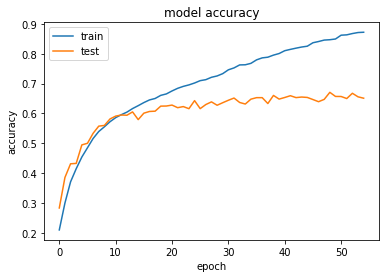

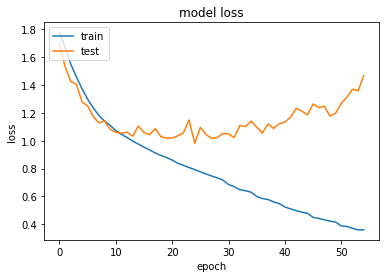

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
x_test =  test_dataset['image']
y_test = test_dataset['label']

#Pandas dataframe to numpy
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)

In [ ]:
model.evaluate(x_test,y_test)


169/169 [==============================] - 2s 10ms/step - loss: 1.3747 - accuracy: 0.6552


[1.3746721744537354, 0.6552426815032959]